In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/roy/AtomCraft/install_release/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

In [2]:
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

# Goal
Time-dependent PF coils
- Create equilibria for various points during the discharge
- Figure out how to link the output from DYON <- look into reverse equilibria creating (what parameters we need etc)
- Diagnostics: Looking into Rogowski Sensors + EFIT + EFIT++ (what do we need to measure)

# Mesh Generation

In [3]:
plasma_dx = 0.01
coil_dx = 0.01
vv_dx = 0.01
vac_dx = 0.06

In [4]:
geom = {
    "limiter": [],
    "vv": {
        "eta": 6.9e-7
    },
    "coils": []
}

In [5]:
def generate_spherical_shell(R0, a, n):
    thetas = np.linspace(0, 2*np.pi, n, endpoint=False)
    Rwalls = R0 + a * np.cos(thetas)
    Zwalls = a * np.sin(thetas)
    return list(zip(Rwalls, Zwalls))

In [10]:
# * Create Limiter and VV
R0 = 0.3048      # Middle of the circle
rwall = 0.16195  # Radius of the circular wall
npoints = 50     # Number of points on the wall

    
geom["limiter"] = generate_spherical_shell(R0, rwall, npoints)
geom["vv"]["vv_inner_cntr"] = generate_spherical_shell(R0, rwall + 0.005, npoints)
geom["vv"]["vv_outer_cntr"] = generate_spherical_shell(R0, rwall + 0.010, npoints)
geom["vv"]["shell_cntr"] = generate_spherical_shell(R0, rwall + 0.015, npoints)

In [11]:
# Create Coils
geom["coils"] = {
    "VF1_U": {
        "rc": 0.20,
        "zc": 0.35,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "VF1_L": {
        "rc": 0.20,
        "zc": -0.35,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "OH1_U": {
        "rc": 0.30,
        "zc": 0.275,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "OH1_L": {
        "rc": 0.275,
        "zc": -0.275,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "SH1_U": {
        "rc": 0.50,
        "zc": 0.10,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "SH1_L": {
        "rc": 0.50,
        "zc": -0.10,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
}

In [12]:
# Create a G-S domain
gs_mesh = gs_Domain()

# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')        # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')    # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vac_dx,'vacuum')       # Define the vacuum inside the VV
gs_mesh.define_region('shell',vv_dx,'conductor',eta=geom['vv']['eta'])  # Define the shells
gs_mesh.define_region('vv',vv_dx,'conductor',eta=geom['vv']['eta'])      # Define the VV

# Define each of the PF coils
for key, coil in geom['coils'].items():
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil['nturns'],coil_set=key[:2])

In [13]:
# Define geometry
gs_mesh.add_polygon(geom['limiter'][:-1], 'plasma', parent_name='vacuum')
gs_mesh.add_polygon(geom['vv']['shell_cntr'], 'shell', parent_name='vacuum')
gs_mesh.add_annulus(geom['vv']['vv_inner_cntr'], 'vacuum', geom['vv']['vv_outer_cntr'], 'vv', parent_name='air')

# Define the shape of the PF coils
for key, coil in geom['coils'].items():
    gs_mesh.add_rectangle(coil['rc'], coil['zc'], coil['w'], coil['h'], key, parent_name='air')
    

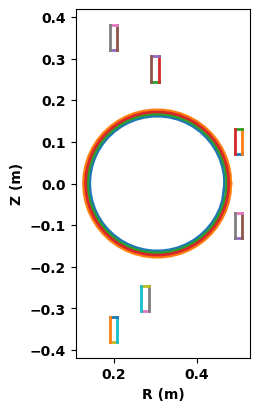

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
gs_mesh.plot_topology(fig, ax)

In [15]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 557
  # of unique segments  = 32
Generating mesh:
  # of points  = 2062
  # of cells   = 4072
  # of regions = 11


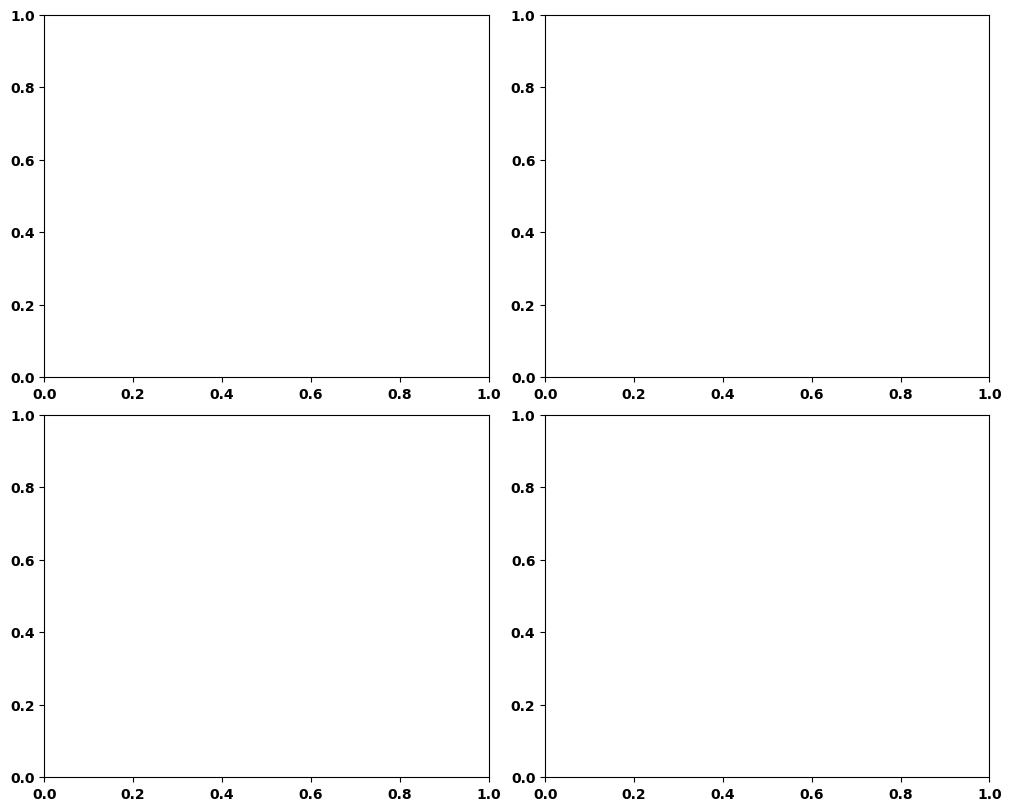

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2,figsize=(10,8),constrained_layout=True)
gs_mesh.plot_mesh(fig, ax)

In [17]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'mesh.h5')

# Compute Equilibria

In [18]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [19]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0=0.125*0.28) # F0 = B0 * R0


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.579E-01
    # of points  =    2062
    # of edges   =    6133
    # of cells   =    4072
    # of boundary points =      50
    # of boundary edges  =      50
    # of boundary cells  =      50
  Resolution statistics:
    hmin =  4.990E-03
    hrms =  1.915E-02
    hmax =  9.256E-02
  Surface grounded at vertex     525


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    6.1655900000000003E-004


In [20]:
# Need to check the bounds for this
# coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
# for name, coil in mygs.coil_sets.items():
#     if name.startswith('OH'):
#         bounds = [-2.00E+04,2.00E+04]
#     elif name.startswith('VF'):
#         bounds = [-1.50E+04,4.20E+04]
#     elif name.startswith('SH'):
#         bounds = [-1.50E+04,1.50E+04]
#     coil_bounds[coil['id'],:] = np.array(bounds)
# 
# mygs.set_coil_bounds(coil_bounds)

In [21]:
Ip_target = 10e3 # Amps

mygs.set_targets(Ip=Ip_target, Ip_ratio=0.02)

In [22]:
isoflux_pts = np.array([
    [0.3, 0.24],
    [0.3, -0.24]
])

mygs.set_isoflux(isoflux_pts)

In [23]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-1*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

# Force shaping coil to 0
# coil_reg_weights[mygs.coil_sets['SH']['id']] = 1.E3

# Set OH current to -8 kA
# coil_reg_targets[mygs.coil_sets['OH']['id']] = -8.E3
# coil_reg_weights[mygs.coil_sets['OH']['id']] = 1.E3

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

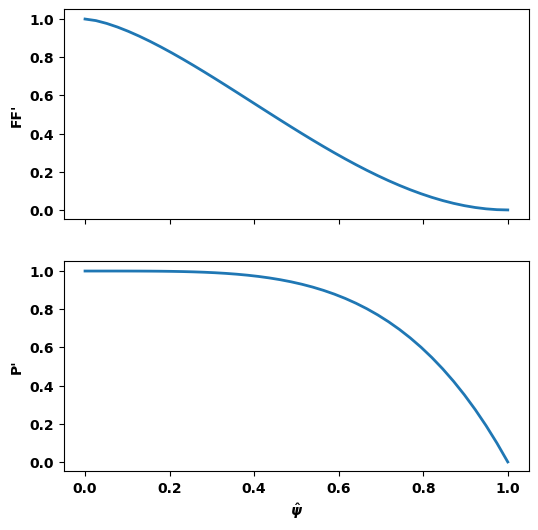

In [24]:
# Set profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [25]:
R0 = 0.28
Z0 = 0.0
a = 0.12
kappa = 1.2
delta = 0.05
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  2.2145E-02  2.0040E+00  2.4326E-04  4.1779E-01  4.0485E-05 -0.0000E+00
     2  4.9942E-02  4.0328E+00  3.0679E-04  4.2721E-01  3.2431E-05 -0.0000E+00
     3  8.4136E-02  6.4681E+00  3.3944E-04  4.3325E-01  5.2704E-05 -0.0000E+00
     4  1.2440E-01  9.2793E+00  3.5905E-04  4.3756E-01  3.1372E-05 -0.0000E+00
     5  1.7051E-01  1.2449E+01  3.7851E-04  4.4084E-01 -1.2585E-05 -0.0000E+00
     6  2.2233E-01  1.5974E+01  3.7621E-04  4.4341E-01  1.8012E-05 -0.0000E+00
     7  2.7958E-01  1.9844E+01  3.7901E-04  4.4554E-01  4.8644E-05 -0.0000E+00
     8  3.4175E-01  2.3952E+01  4.2736E-04  4.4731E-01  6.7616E-05 -0.0000E+00
     9  4.1055E-01  2.8698E+01  4.2535E-04  4.4883E-01  6.3196E-05 -0.0000E+00
    10  4.8881E-01  3.3747E+01  4.4298E-04  4.5015E-01  6.4151E-05 -0.0000E+00
    11  5.7417E-01  3.9388E+01  4.2239E-04  4.5131E-01  6.1362E-05 -0.0000E+00
    12  6.6892E-01  4.5557E+01  4.0579E-04  4.5234E-01  4.4205E-05 -0.0000E+00
    13  7.7148E-01  5.

/home/roy/AtomCraft/install_release/python/OpenFUSIONToolkit/TokaMaker/_core.py:770: RuntimeWarning: divide by zero encountered in divide
  psi = (psi-psi_lim.value)/(psi_max.value-psi_lim.value)
/home/roy/AtomCraft/install_release/python/OpenFUSIONToolkit/TokaMaker/_core.py:770: RuntimeWarning: invalid value encountered in divide
  psi = (psi-psi_lim.value)/(psi_max.value-psi_lim.value)


ValueError: z array must not contain non-finite values within the triangulation

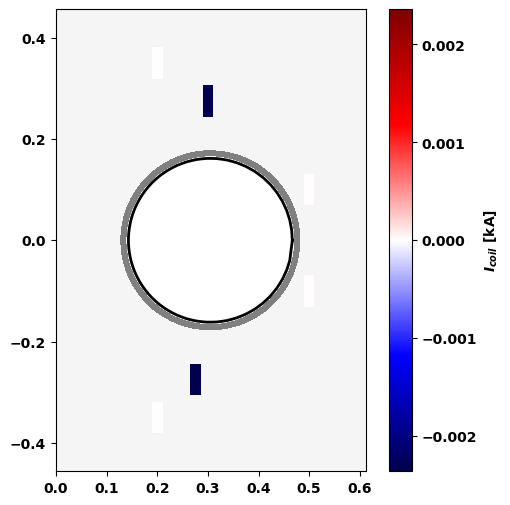

In [26]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=8)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

In [27]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

           1  0.45506804570580112        0.0000000000000000        0.0000000000000000     
           2  0.45506804570580112        0.0000000000000000        0.0000000000000000     


[    0] WARNING: gs_get_qprof: Trace did not complete
[    0] WARNING: gs_get_qprof: Trace did not complete


           3  0.45506804570580112        0.0000000000000000        0.0000000000000000     


[    0] WARNING: gs_get_qprof: Trace did not complete


ZeroDivisionError: float division by zero